Trying out tutorial: 
https://towardsdatascience.com/forecasting-with-machine-learning-models-95a6b6579090
Expected to work great on high-frequency timeseries and missing gaps.

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

Adding all data and plotting it

/var/folders/fw/85gqx2x15rz56hqss4b_s0mh0000gn/T/ipykernel_32295/3743776553.py:5: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../online_data/new_online_data.csv", sep=',', names=headers, parse_dates=parse_dates, skiprows=1)


[49 93 96 97 50 47 54 94]


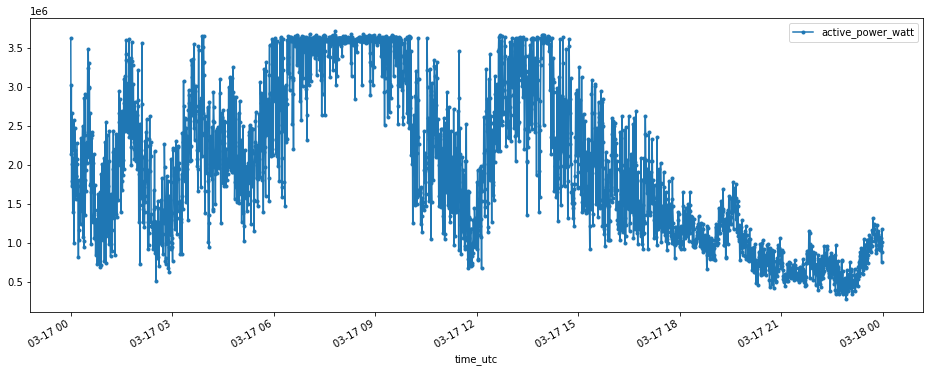

In [54]:
#import data
headers = ['time_utc', 'external_mapping_id', 'active_power_watt','possible_power_watt','wind_speed','rpm','active_stop','control_state_id','online_data_expired','wind_direction','temperature','active_stop_user_id','received_time_utc']

parse_dates = ['time_utc', 'received_time_utc']
df = pd.read_csv("../../AssetsData/new_online_data.csv", sep=',', names=headers, parse_dates=parse_dates, skiprows=1)


# dropping empty values
df.dropna(subset=['wind_speed', 'temperature', 'wind_direction'], inplace=True, axis=0)
indexNames = df[df['rpm'] < 0 ].index
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

# dropping empty values
indexNames = df[df['active_power_watt'] < 0 ].index
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

df = df[['external_mapping_id','time_utc','active_power_watt']]
df.columns = ['id', 'time_utc', 'active_power_watt']
dtypes = {
    'id':np.uint8,
    'active_power_watt':np.int64
}
df = df.astype(dtypes)
print(df['id'].unique())
# specifying an ID to do this for
df = df[df['id'] == 47]
cond1 = (df.time_utc > pd.Timestamp(2022,3,17,0,0)) & (df.time_utc < pd.Timestamp(2022,3,18,0,0))
df = df.loc[cond1]

df.sort_values(by='time_utc', ascending=True, inplace=True)
# and rename the control state ids to more meaningful values

df = df.set_index('time_utc')
#print(f'Number of rows with missing values: {df.isnull().any(axis=1)}')
df = df.sort_index()
df.index = df.index.round('30s')


df[df.index.duplicated()]
df = df[~df.index.duplicated()]

df = df[['active_power_watt']]

df.plot(marker='.', figsize=(16, 6));
#print(df['id'].unique())

Split the data into a validation set and use a horizon(amount of datapoints you want to split it at)

In [55]:
valid_horizon = 150
train = df.head(-valid_horizon).copy()
y_valid = df.tail(valid_horizon)['active_power_watt']

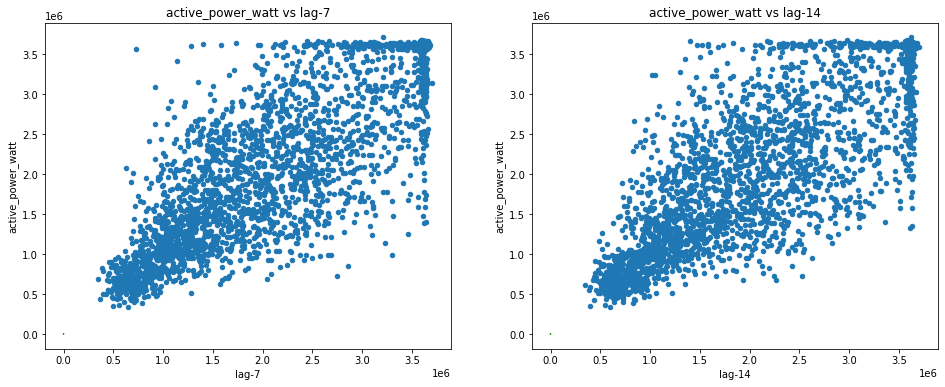

In [56]:
train['lag-7'] = train['active_power_watt'].shift(7)
train['lag-14'] = train['active_power_watt'].shift(14)

fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

for lag, axi in zip((7, 14), ax.flat):
    train.plot.scatter(x=f'lag-{lag}', y='active_power_watt', ax=axi)
    axi.plot([-1, 7], [-1, 7], c='g')
    axi.set_title(f'active_power_watt vs lag-{lag}')

In [57]:
train.isnull().sum()

active_power_watt     0
lag-7                 7
lag-14               14
dtype: int64

In [58]:
train_without_nulls = train.dropna()
X_train = train_without_nulls.drop(columns='active_power_watt')
y_train = train_without_nulls['active_power_watt']

In [59]:
lr = LinearRegression(fit_intercept=False).fit(X_train, y_train)
lr.coef_

array([0.52988505, 0.45045102])

In [60]:
next_lags_7 = y_train.tail(7).values
next_lags_7

array([660900, 420800, 625800, 348700, 608200, 553900, 437800])

In [61]:
next_lags_14 = y_train.tail(14).values
next_lags_14

array([525600, 723100, 645000, 500300, 691800, 770600, 366500, 660900,
       420800, 625800, 348700, 608200, 553900, 437800])

In [62]:
X_valid1 = pd.DataFrame({
    'lag-7': next_lags_7,
    'lag-14': next_lags_14[:7],
})
X_valid1

lag-7  lag-14
0  660900  525600
1  420800  723100
2  625800  645000
3  348700  500300
4  608200  691800
5  553900  770600
6  437800  366500

In [63]:
forecasts_7 = lr.predict(X_valid1)
forecasts_7

array([586958.08878718, 548696.76447812, 622142.97548885, 410131.56439947,
       633898.10639971, 640620.88858086, 397073.97583519])

In [64]:
X_valid2 = pd.DataFrame({
    'lag-7': forecasts_7,
    'lag-14': next_lags_14[-7:],
})
X_valid2

lag-7  lag-14
0  586958.088787  660900
1  548696.764478  420800
2  622142.975489  625800
3  410131.564399  348700
4  633898.106400  608200
5  640620.888581  553900
6  397073.975835  437800

In [65]:
forecasts_7_14 = lr.predict(X_valid2)
y_pred = np.hstack([forecasts_7, forecasts_7_14])
y_pred

array([586958.08878718, 548696.76447812, 622142.97548885, 410131.56439947,
       633898.10639971, 640620.88858086, 397073.97583519, 608723.39856416,
       480296.0042597 , 611556.51323455, 374394.8571761 , 609857.44340742,
       588960.25468985, 407611.02225316])

In [66]:
train_mlfcst = train.reset_index()[['time_utc', 'active_power_watt']]
train_mlfcst.rename(columns = {'time_utc':'ds', 'active_power_watt':'y'}, inplace = True)
train_mlfcst.index = pd.Index(np.repeat(0, train.shape[0]), name='unique_id')
train_mlfcst.head()

ds        y
unique_id                             
0         2022-03-17 00:00:00  3625200
0         2022-03-17 00:00:30  2141000
0         2022-03-17 00:01:00  3019000
0         2022-03-17 00:01:30  1728500
0         2022-03-17 00:02:00  2659600

In [67]:
from mlforecast.core import TimeSeries
from mlforecast.forecast import Forecast

In [49]:
ts = TimeSeries(freq = '30S', lags=[7, 14])
ts

TimeSeries(freq=<Day>, transforms=['lag-7', 'lag-14'], date_features=[], num_threads=1)

In [50]:
model = LinearRegression(fit_intercept=False)

In [51]:
fcst = Forecast(model, ts)
fcst.fit(train_mlfcst)

Forecast(model=LinearRegression(fit_intercept=False), ts=TimeSeries(freq=<Day>, transforms=['lag-7', 'lag-14'], date_features=[], num_threads=1))

In [52]:
y_pred_mlfcst = fcst.predict(14)
y_pred_mlfcst

ds        y_pred
unique_id                                  
0         2022-03-18 22:44:30  586958.12500
0         2022-03-19 22:44:30  548696.75000
0         2022-03-20 22:44:30  622143.00000
0         2022-03-21 22:44:30  410131.56250
0         2022-03-22 22:44:30  633898.12500
0         2022-03-23 22:44:30  640620.93750
0         2022-03-24 22:44:30  397074.00000
0         2022-03-25 22:44:30  608723.43750
0         2022-03-26 22:44:30  480296.03125
0         2022-03-27 22:44:30  611556.56250
0         2022-03-28 22:44:30  374394.87500
0         2022-03-29 22:44:30  609857.50000
0         2022-03-30 22:44:30  588960.31250
0         2022-03-31 22:44:30  407611.06250